In [864]:
# !pip install yellowbrick

In [1]:
import pandas as pd
import numpy as np
from itertools import cycle

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, estimate_bandwidth, MeanShift, SpectralClustering, OPTICS, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestCentroid
from sklearn import metrics

from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline

## Importing and cleaning data

In [2]:
# Import data and clean up dataframe
data = pd.read_csv('irisdata.txt', sep = ',', header = None)
data.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
data.at[34, 'Petal Width'] = 0.2
data.at[37, 'Sepal Width'] = 3.6
data.at[37, 'Petal Length'] = 1.4

## Elbow Plot

In [ ]:
# Create an elbow plot using k-means 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data.loc[:, data.columns != 'Species'])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# create an elbow plot using KElbowVisualizer from the yellowbrick package
# default metric: distortion
visualizer1 = KElbowVisualizer(KMeans(),k=(2,10),timings=False)

visualizer1.fit(data.loc[:, data.columns != 'Species'])
visualizer1.show()



In [ ]:
# metric 2: silhouette
visualizer2 = KElbowVisualizer(KMeans(),k=(2,10),metric='silhouette',timings=False)

visualizer2.fit(data.loc[:, data.columns != 'Species'])
visualizer2.show()

In [ ]:
# metric 3: calinski_harabasz
visualizer3 = KElbowVisualizer(KMeans(),k=(2,10),metric='calinski_harabasz',timings=False)

visualizer3.fit(data.loc[:, data.columns != 'Species'])
visualizer3.show()

## PCA

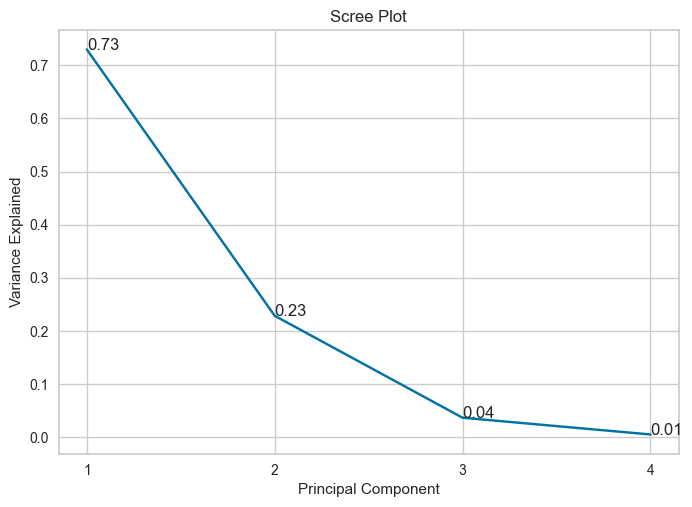

In [3]:
#SCREE plot to determine how many components to use
features = data[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']]
scaled_features = StandardScaler().fit_transform(features)
scree_pca = PCA(n_components=4)
scree_fit = scree_pca.fit(scaled_features)

PC_values = np.arange(scree_pca.n_components_) + 1

plt.plot(PC_values,scree_pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.xticks(ticks=[1,2,3,4])
plt.ylabel('Variance Explained')
for a,b in zip(PC_values,scree_pca.explained_variance_ratio_):
    plt.text(a,b, str(round(b,2)))
plt.show()

As shown with our scree plot, PC4 only explains ~1% of the variance, so we can explain 99% of our variance using only 3 features.

In [4]:
# Reduce dataframe using PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(principalComponents,columns=['PC1','PC2','PC3'])
pca_df.head()

,PC1,PC2,PC3
0,-2.264703,0.480027,-0.127706
1,-2.080961,-0.674134,-0.234609
2,-2.364229,-0.341908,0.044201
3,-2.299384,-0.597395,0.091290
4,-2.389842,0.646835,0.015738


In [ ]:
# 2d scatter plot of PCA
fig = px.scatter(pca_df, x='PC1', y='PC2', color=data['Species'])
fig.show()

In [ ]:
# 3d plot of PCA
px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color = data['Species'], color_discrete_sequence = px.colors.qualitative.Prism,
             title = 'PCA 3d Plot')

## K-Means Clustering

#### PCA Reduced Dataset

In [ ]:
# x and y values using pca reduced dataset
k_x_pca = principalComponents
k_y_pca = data.loc[:, data.columns == 'Species'].values

In [ ]:
# K-Means using pca reduced dataset and assocaited attributes
kmeans_pca = KMeans(n_clusters=3, random_state=0)
y_kmeans_pca = kmeans_pca.fit_predict(k_x_pca)
k_centers_pca = kmeans_pca.cluster_centers_
k_n_clusters_pca = len(k_centers_pca)
k_labels_pca = kmeans_pca.labels_

In [ ]:
# create scatter plot of k-means clusters using pca reduced dataset
plt.figure(1, figsize=[10,6])
plt.scatter(k_x_pca[y_kmeans_pca == 0, 0], k_x_pca[y_kmeans_pca == 0, 1], s=50,
           c='peachpuff', marker='D', edgecolor='black', label='Versicolor')
plt.scatter(k_x_pca[y_kmeans_pca == 1, 0], k_x_pca[y_kmeans_pca == 1, 1], s=50,
           c='skyblue', marker='^', edgecolor='black', label='Setosa')
plt.scatter(k_x_pca[y_kmeans_pca == 2, 0], k_x_pca[y_kmeans_pca == 2, 1], s=50,
           c='lemonchiffon', marker='s', edgecolor='black', label='Virginica')
plt.scatter(k_centers_pca[:,0], k_centers_pca[:, 1], s=250,
           marker='o', edgecolor='red', linewidth=2.2, facecolor='none', label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

The scatter plot using k-means clustering on the reduced pca dataset produces fairly good clusters for each species of Iris. 

In [ ]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
k_y_pca = k_y_pca.flatten()
k_y_pca = np.vectorize(d.get)(k_y_pca)

In [ ]:
# calculate statistics on k-means using pca reduced dataset
print('Estimated number of clusters: %d' % k_n_clusters_pca)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(k_y_pca, k_labels_pca))
print("Completeness: %0.3f" % metrics.completeness_score(k_y_pca, k_labels_pca))
print("V-measure: %0.3f" % metrics.v_measure_score(k_y_pca, k_labels_pca))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(k_y_pca, k_labels_pca))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(k_y_pca, k_labels_pca))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(k_x_pca, k_labels_pca, metric='sqeuclidean'))

The statitics here show that using pca we have a decent clustering algorithm for the pca reduced dataset.

In [ ]:
#### Original Dataset

In [ ]:
# x and y values using original dataset
k_x = data.loc[:, data.columns != 'Species'].values
k_y = data.loc[:, data.columns == 'Species'].values

In [ ]:
# K-Means using original dataset values and assocaited attributes
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_kmeans = kmeans.fit_predict(k_x)
k_centers = kmeans.cluster_centers_
k_n_clusters = len(k_centers)
k_labels = kmeans.predict(k_x)

In [ ]:
# 2d scatter plot of K-Means Clustering
plt.figure(1, figsize=[10,6])
plt.scatter(k_x[y_kmeans == 0, 1], k_x[y_kmeans == 0, 3], s=50,
           c='peachpuff', marker='D', edgecolor='black', label='Versicolor')
plt.scatter(k_x[y_kmeans == 1, 1], k_x[y_kmeans == 1, 3], s=50,
           c='skyblue', marker='^', edgecolor='black', label='Setosa')
plt.scatter(k_x[y_kmeans == 2, 1], k_x[y_kmeans == 2, 3], s=50,
           c='lemonchiffon', marker='s', edgecolor='black', label='Virginica')
plt.scatter(k_centers[:,1], k_centers[:, 3], s=250,
           marker='o', edgecolor='red', linewidth=2.2, facecolor='none', label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

The scatter plot using k-means clustering on the original dataset produces good clusters that do not appear to be quite as good as the pca reduced dataset k-means clustering.

In [ ]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
k_y = k_y.flatten()
k_y = np.vectorize(d.get)(k_y)

In [ ]:
# calculate statistics on k-means using original dataset
print('Estimated number of clusters: %d' % k_n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(k_y, k_labels))
print("Completeness: %0.3f" % metrics.completeness_score(k_y, k_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(k_y, k_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(k_y, k_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(k_y, k_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(k_x, k_labels, metric='sqeuclidean'))

Despite the scatter plot appearing to show a less accurate clusting on the original dataset, the statistics calculated here say otherwise. 

#### K-Means Conclusions

Using k-means clustering on both the pca reduced dataset and the original dataset produces good clustering for identifying the species of Iris. However, doing pca does not appear to be benifical in creating a superior model in this case. 

## Affinity Propogation

#### PCA Reduced Dataset

In [ ]:
# x and y values using pca reduced dataset
affinity_x_pca = principalComponents
affinity_y_pca = data.loc[:, data.columns == 'Species'].values

In [ ]:
# Affinity Propagation using pca reduced dataset and assocaited attributes
ap_pca = AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True, damping=0.5, max_iter=200, 
                         preference=-20, verbose=False, random_state=0)
ap_pca.fit(affinity_x_pca)
y_affinity_pca = ap_pca.fit_predict(affinity_x_pca)
a_centers_pca = ap_pca.cluster_centers_
a_indices_pca = ap_pca.cluster_centers_indices_
a_n_clusters_pca = len(a_centers_pca)
a_labels_pca = ap_pca.predict(affinity_x_pca)

In [ ]:
# 2d scatter plot of Affinity Propagation Clustering
plt.figure(1, figsize=[10,6])
plt.scatter(affinity_x_pca[:, 0], affinity_x_pca[:, 1], c=a_labels_pca, s=50)

In [ ]:
# Affinity Propagation plot
plt.close("all")
plt.figure(1, figsize=[10,6])
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(a_n_clusters_pca), colors):
    class_members = a_labels_pca == k
    cluster_center = affinity_x_pca[a_indices_pca[k]]
    plt.plot(affinity_x_pca[class_members, 0], affinity_x_pca[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in affinity_x_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % a_n_clusters_pca)
plt.show()

Looking at the plots above it appears that affinity propagation using the pca reduced dataset results in a total of 5 estimated clusters, 2 more than we have species of Iris. 

In [ ]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
affinity_y_pca = affinity_y_pca.flatten()
affinity_y_pca = np.vectorize(d.get)(affinity_y_pca.flatten())

In [ ]:
# calculate statistics on affinity propagation using pca reduced dataset
print('Estimated number of clusters: %d' % a_n_clusters_pca)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(affinity_y_pca, a_labels_pca))
print("Completeness: %0.3f" % metrics.completeness_score(affinity_y_pca, a_labels_pca))
print("V-measure: %0.3f" % metrics.v_measure_score(affinity_y_pca, a_labels_pca))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(affinity_y_pca, a_labels_pca))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(affinity_y_pca, a_labels_pca))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(affinity_x_pca, a_labels_pca, metric='sqeuclidean'))

As suspected based on the visualizations of the affinity propagation on the pca reduced dataset, the statitics confirm that this has not resulted in incredibly strong clustering with relatively low scores in all statistics besides homogeneity.

#### Original Dataset

In [ ]:
# x and y values using original dataset
affinity_x = data.loc[:, data.columns != 'Species'].values
affinity_y = data.loc[:, data.columns == 'Species'].values

In [ ]:
# Affinity Propagation using original dataset and assocaited attributes
ap = AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True, damping=0.5, max_iter=200, 
                         preference=-20, verbose=False, random_state=0)
ap.fit(affinity_x)
y_affinity = ap.fit_predict(affinity_x)
a_centers = ap.cluster_centers_
a_indices = ap.cluster_centers_indices_
a_n_clusters = len(a_centers)
a_labels = ap.predict(affinity_x)

In [ ]:
# 2d scatter plot of Affinity Propagation Clustering
plt.figure(1, figsize=[10,6])
plt.scatter(affinity_x[:, 0], affinity_x[:, 1], c=a_labels, s=50)

In [ ]:
# Affinity Propagation plot 
plt.close("all")
plt.figure(1, figsize=[10,6])
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(a_n_clusters), colors):
    class_members = a_labels == k
    cluster_center = affinity_x[a_indices[k]]
    plt.plot(affinity_x[class_members, 0], affinity_x[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in affinity_x[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % a_n_clusters)
plt.show()

The plots above for affinity propagation on the original dataset show much better clustering that we achieved using the pca reduced dataset. 

In [ ]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
affinity_y = affinity_y.flatten()
affinity_y = np.vectorize(d.get)(affinity_y.flatten())

In [ ]:
# calculate statistics on affinity propagation using original dataset
print('Estimated number of clusters: %d' % a_n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(affinity_y, a_labels))
print("Completeness: %0.3f" % metrics.completeness_score(affinity_y, a_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(affinity_y, a_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(affinity_y, a_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(affinity_y, a_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(affinity_x, a_labels, metric='sqeuclidean'))

Unlike the statistics we calulated using the pca reduced dataset, here we have very strong indications, on all calculated statistics, that affinity propagation did very good at clustering the species of Iris together.

#### Affinity Propagation Conclusions

Using affinity propagation clustering on the original dataset produced a good result for correctly identifying the species of Iris. However, when affinity propagation was used against the pca reduced dataset it did not perform nearly as well, resulting in 2 excess clusters.

## Gaussian Mixtures

In [ ]:
# Copying the data
gmm_iris_df = scaled_features.copy() # Original Data
gmm_iris_df = pd.DataFrame(gmm_iris_df, columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
gmm_pca_df = pca_df.copy() # PCA Data

# Performing Gaussian Mixtures on the Original Data
gmm = GaussianMixture(n_components=3)
gmm.fit(gmm_iris_df)
labels = gmm.predict(gmm_iris_df)
gmm_iris_df['labels'] = labels
gmm_iris_df['Species'] = data['Species']

# Performing Gaussian Mixtures on the PCA Data
gmm = GaussianMixture(n_components=3)
gmm.fit(pca_df)
labels = gmm.predict(pca_df)
gmm_pca_df['labels'] = labels
gmm_pca_df['Species'] = data['Species']

Plotting the PCA Data

In [ ]:
# Creating a 3D Plot
fig = px.scatter_3d(gmm_pca_df, x='PC1', y='PC2', z='PC3', color='labels', symbol='Species', opacity=0.7)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

In [ ]:
# Creating a 2D Plot
sns.scatterplot(x='PC1', y='PC2', hue='labels', style='Species', data=gmm_pca_df)
plt.show()

We see that Iris-Setosa has its own cluster on the side and Iris-Versicolor and Iris-Virginica's clusters very slightly intersect.

Plotting the Original Data

In [ ]:
# Creating a 3D plot
fig = px.scatter_3d(gmm_iris_df, x='Sepal Length', y='Sepal Width', z='Petal Length', color='labels', symbol='Species', opacity=0.7)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

In [ ]:
# Creating a 2D plot
sns.scatterplot(x='Sepal Length', y='Sepal Width', hue='labels', style='Species', data=gmm_iris_df)
plt.show()

Iris-Setosa still has its own cluster but Iris-Versicolor and Iris-Virginica's clusters are much more muddy

### Conclusions: Gaussian Mixtures

Compared to the model on the original data, the gaussian mixtures model almost cleanly divides Iris-Versicolor and Iris-Virginica into their own clusters. There is some error and a small overlap.

## Ward Agglomerative Clustering (Hierachical)

In [23]:
ward = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward')

ward_predict = ward.fit_predict(features)
ward_labels = ward.labels_
ward_clusters = ward.n_clusters_

ward_clf = NearestCentroid()
ward_clf.fit(features,ward_predict)
ward_centroids = pd.DataFrame(ward_clf.centroids_,columns=['Sepal Length','Sepal Width','Petal Length','Petal Width'])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [30]:
# scatter plot
ward_df = data.copy()
ward_df['Cluster'] = ward_predict
ward_df['Cluster'] = ward_df['Cluster'].astype('category')
fig = px.scatter(
    ward_df,
    x='Petal Length',
    y='Petal Width',
    color='Cluster',
    color_discrete_sequence=px.colors.qualitative.Antique,
    symbol= 'Species'
)
fig.add_trace(px.scatter(ward_centroids,x='Petal Length',y='Petal Width',text=ward_centroids.index).data[0])
fig.show()

Based on the scatter plot (and the corresponding legend), we can see 1 cluster encompassed a single species (setosa). The other 2 clusters were some mix of versicolor and virginica.

In [19]:
# function to map cluster to a the closest species
def species_map(predict,sp0, sp1, sp2):
    new_labels=[]
    for i in predict:
        if i == 0:
            new_labels.append(sp0)
        elif i == 1:
            new_labels.append(sp1)
        else: 
            new_labels.append(sp2)
    return np.array(new_labels)


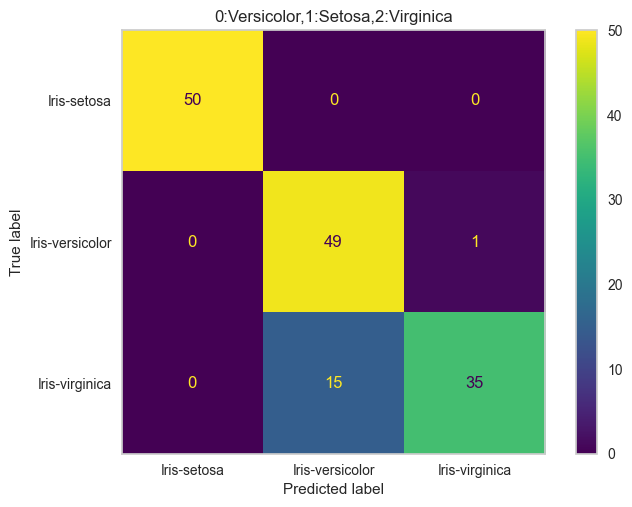

In [34]:
# confusion matrix
new_labels = species_map(ward_predict, 'Iris-versicolor','Iris-setosa','Iris-virginica')
metrics.ConfusionMatrixDisplay.from_predictions(data['Species'],new_labels)
plt.grid(visible=None)
plt.title('0:Versicolor,1:Setosa,2:Virginica')
plt.show()

This confusion matrix confirms that all setosa flowers were clustered together, and there weren't any other species of flower mixed into that cluster. However, about 15 virginica flowers were clustered with 49 of the 50 versicolor flowers, and the remaining versicolor flower was clustered with the remaining 35 virginica flowers.

In [26]:
# Statistics

print('Estimated number of clusters: %d' % ward_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data["Species"],ward_labels))
print("Completeness: %0.3f" % metrics.completeness_score(data["Species"],ward_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(data["Species"],ward_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(data["Species"],ward_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(data["Species"],ward_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(features, ward_labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.761
Completeness: 0.780
V-measure: 0.770
Adjusted Rand Index: 0.731
Adjusted Mutual Information: 0.767
Silhouette Coefficient: 0.735


### Ward Hierarchical Clustering for PCA dataframe

In [29]:
ward_p = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward')

ward_predict_pca = ward_p.fit_predict(pca_df)
ward_labels_pca = ward_p.labels_
ward_clusters_pca = ward_p.n_clusters_

ward_clf_pca = NearestCentroid()
ward_clf_pca.fit(pca_df,ward_predict_pca)
ward_centroids_pca = pd.DataFrame(ward_clf_pca.centroids_,columns=['PC1','PC2','PC3'])

In [33]:
# scatter plot (displaying all 3 principal components)
ward_pca = pca_df.copy()
ward_pca['Species'] = data['Species']
ward_pca['Cluster'] = ward_labels_pca
ward_pca['Cluster'] = ward_pca['Cluster'].astype('category')

fig = px.scatter_3d(
    ward_pca,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    color_discrete_sequence=px.colors.qualitative.Antique,
    symbol= 'Species'
)
fig.add_trace(px.scatter_3d(ward_centroids_pca,x='PC1',y='PC2',z='PC3',text=ward_centroids_pca.index).data[0])
fig.update_traces(marker_size=5)
fig.show()

By briefly observing this scatter plot, we can see that there was one cluster that included at least 1 of each species, but the other 2 clusters included only 1 species.

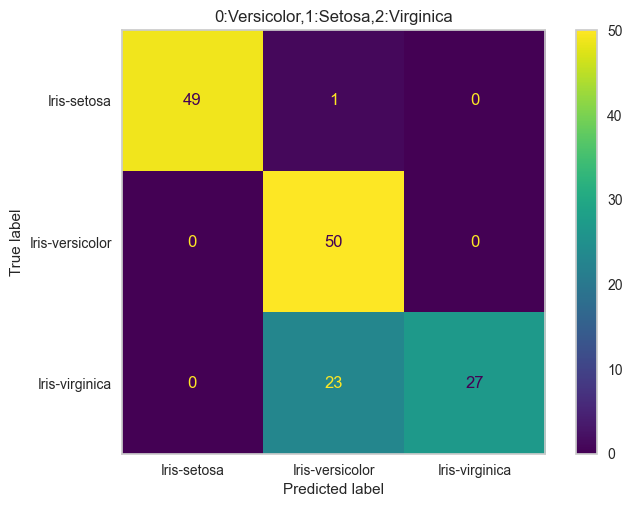

In [36]:
# confusion matrix
new_labels = species_map(ward_predict_pca, 'Iris-versicolor','Iris-setosa','Iris-virginica')
metrics.ConfusionMatrixDisplay.from_predictions(data['Species'],new_labels)
plt.grid(visible=None)
plt.title('0:Versicolor,1:Setosa,2:Virginica')
plt.show()

This time around all versicolor flowers were included in the same cluster, but that cluster also included a setosa flower and 23 virginica flowers. The 2nd cluster included all the remaining setosa flowers, with no other flowers from another iris species. And the 3rd cluster had the last 27 flowers, all virginica.

In [37]:
print('Estimated number of clusters: %d' % ward_clusters_pca)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data["Species"],ward_labels_pca))
print("Completeness: %0.3f" % metrics.completeness_score(data["Species"],ward_labels_pca))
print("V-measure: %0.3f" % metrics.v_measure_score(data["Species"], ward_labels_pca))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(data["Species"],ward_labels_pca))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(data["Species"],ward_labels_pca))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(pca_df, ward_labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.692
Completeness: 0.743
V-measure: 0.717
Adjusted Rand Index: 0.630
Adjusted Mutual Information: 0.713
Silhouette Coefficient: 0.633


### Ward Hierarchical Clustering Conclusions:

Hierarchical clustering does a pretty good job of clustering setosa irises together, but has a little bit of a harder time separating out virginica and versicolor. It does a good job capturing all (or a large majority) of the versicolor irises in one cluster, but there are 15-23 virginica flowers included in that cluster as well, but all remaining virginica, and the few versicolor flowers are in the last cluster. Notably, clustering the original features does perform better (when comparing to the Species listed for the original dataset) than the PCA components.

### Mean Shift

In [ ]:
# Apply Mean Shift to original dataframe
bandwidth = estimate_bandwidth(scaled_features, quantile = 0.2, n_samples = len(scaled_features))
mean_shift = MeanShift(bandwidth = bandwidth, bin_seeding = True)
mean_shift.fit(scaled_features)
ms_data_labels = mean_shift.labels_
ms_data_cluster_centers = mean_shift.cluster_centers_

unique_ms_data_labels = np.unique(ms_data_labels)
num_ms_data_clusters_ = len(unique_ms_data_labels)
print("Number of clusters : %d" % num_ms_data_clusters_)
print(ms_data_cluster_centers)

Applying Mean Shift to the original dataframe results in the identification of 3 clusters and produces the coordinates for each cluster.

In [ ]:
# Create plot of clusters derived from original data
plt.scatter(scaled_features[:,0], scaled_features[:,1], c = ms_data_labels, cmap = 'rainbow', edgecolors = 'b')
plt.scatter(ms_data_cluster_centers[:,0], ms_data_cluster_centers[:,1],
     color = 'k', s = 20, linewidths = 5)
plt.show()

The scatter plot depicts the relationship between the original data points and the clusters identified by the Mean Shift.

In [ ]:
# Apply Mean Shift to PCA dataframe
bandwidth = estimate_bandwidth(scaled_features, quantile = 0.2, n_samples = len(pca_df))
mean_shift = MeanShift(bandwidth = bandwidth, bin_seeding = True)
mean_shift.fit(pca_df)
ms_pcs_labels = mean_shift.labels_
ms_pcs_cluster_centers = mean_shift.cluster_centers_

unique_ms_pcs_labels = np.unique(ms_pcs_labels)
num_ms_pcs_clusters_ = len(unique_ms_pcs_labels)
print("Number of clusters : %d" % num_ms_pcs_clusters_)
print(ms_pcs_cluster_centers)

Applying Mean Shift to the PCA dataframe results in the identification of 4 clusters and produces the coordinates for each cluster.

In [ ]:
# Create plot of clusters derived from principal components
plt.scatter(pca_df['PC1'], pca_df['PC2'], c = ms_pcs_labels, cmap = 'rainbow', edgecolors = 'b')
plt.scatter(ms_pcs_cluster_centers[:,0], ms_pcs_cluster_centers[:,1],
     color = 'k', s = 20, linewidths = 5)
plt.show()

The scatter plot depicts the relationship between the principal components and the clusters identified by the Mean Shift.

### Conclusions: Mean shift

The application of Mean Shift to the principal components appears to provide better results than seen with the application of the technique to the original dataset, as the distribution of the data points has a much narrower spreads. That is, the clusters become more apparent when derived from the principal components.

### Spectral Clustering

In [ ]:
# Apply Spectral Clustering to original dataframe
spec_clust = SpectralClustering(n_clusters = 3)
spec_clust.fit(scaled_features)
sc_data_labels = spec_clust.labels_
unique_sc_data_labels = np.unique(sc_data_labels)
num_sc_data_clusters_ = len(unique_sc_data_labels)

In [ ]:
# Create Spectral Clustering plot
plt.scatter(scaled_features[:,0], scaled_features[:,1], c = sc_data_labels, cmap = 'rainbow', edgecolors = 'b')
plt.show()

In [ ]:
# Apply Spectral Clustering to PCA dataframe
spec_clust = SpectralClustering(n_clusters = 3)
spec_clust.fit(pca_df)
sc_pcs_labels = spec_clust.labels_
unique_sc_pcs_labels = np.unique(sc_pcs_labels)
num_sc_pcs_clusters_ = len(unique_sc_pcs_labels)

In [ ]:
# Create Spectral Clustering plot
plt.scatter(pca_df['PC1'], pca_df['PC2'], c = sc_pcs_labels, cmap = 'rainbow', edgecolors = 'b')
plt.show()

### Conclusions: Spectral Clustering
Similarly, utilizing the principal components in the application of Spectral Clustering proves to generate improved results when compared to the results associated with the original dataset. The clusters are more well-defined due to the more compact distribution of data.

## DBSCAN Clustering

In [ ]:
# Copying the original and PCA Data
dbscan_iris_df = scaled_features.copy()
dbscan_iris_df = pd.DataFrame(dbscan_iris_df, columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
dbscan_pca_df = pca_df.copy()

# Performing Dbscan on the Original Data
dbscan = DBSCAN()
dbscan.fit(dbscan_iris_df)
labels = dbscan.labels_
dbscan_iris_df['labels'] = labels
dbscan_iris_df['Species'] = data['Species']

# Performing Dbscan on the PCA Data
dbscan = DBSCAN()
dbscan.fit(dbscan_pca_df)
labels = dbscan.labels_
dbscan_pca_df['labels'] = labels
dbscan_pca_df['Species'] = data['Species']

Plotting the PCA Data

In [ ]:
# Creating a 3D Plot
fig = px.scatter_3d(dbscan_pca_df, x='PC1', y='PC2', z='PC3', color='labels', symbol='Species', opacity=0.7)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

In [ ]:
# Creating a 2D Plot
sns.scatterplot(x='PC1', y='PC2', hue='labels', style='Species', data=dbscan_pca_df)
plt.show()

DBSCAN creates 3 clusters, 1 of most of Iris-Setosa, another of most of Iris-Versicolor and Iris-Virginica, and the third seems to be the outliers.

Plotting the Original Data

In [ ]:
# Creating a 3D Plot
fig = px.scatter_3d(dbscan_iris_df, x='Sepal Length', y='Sepal Width', z='Petal Length', color='labels', symbol='Species', opacity=0.7)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

In [ ]:
# Creating a 2D Plot
sns.scatterplot(x='Sepal Length', y='Sepal Width', hue='labels', style='Species', data=dbscan_iris_df)
plt.show()

DBSCAN again finds 3 clusters, however they are even less segregated.

### Conclusions: DBSCAN

DBSCAN almost successfully clusters Iris-Setosa as its own cluster, but then fails to find any meaningful cluster for the other two species, creating the third as a group of seemily outliers from all species.

## OPTICS Clustering

In [ ]:
# Copying the original and PCA data
optics_iris_df = scaled_features.copy()
optics_iris_df = pd.DataFrame(optics_iris_df, columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
optics_pca_df = pca_df.copy()

# Performing Optics on the Original Data
optics = OPTICS(min_samples=5, xi=.05, min_cluster_size=.05)
optics.fit(optics_iris_df)
labels = optics.labels_
optics_iris_df['labels'] = labels
optics_iris_df['Species'] = data['Species']

# Performing Optics on the PCA Data
optics = OPTICS(min_samples=5, xi=.05, min_cluster_size=.05)
optics.fit(pca_df)
labels = optics.labels_
optics_pca_df['labels'] = labels
optics_pca_df['Species'] = data['Species']

Plotting the PCA Data

In [ ]:
# Creating a 3D Plot
fig = px.scatter_3d(optics_pca_df, x='PC1', y='PC2', z='PC3', color='labels', symbol='Species', opacity=0.7)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

In [ ]:
# Creating a 2D Plot
sns.scatterplot(x='PC1', y='PC2', hue='labels', style='Species', data=optics_pca_df)
plt.show()

Optics has identified many smaller clusters while classing the rest as a singular cluster

Plotting Optics Clustering on the Original Data

In [ ]:
# Creating a 3D Plot
fig = px.scatter_3d(optics_iris_df, x='Sepal Length', y='Sepal Width', z='Petal Length', color='labels', symbol='Species', opacity=0.7)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

In [ ]:
# Creating a 2D Plot
sns.scatterplot(x='Sepal Length', y='Sepal Width', hue='labels', style='Species', data=optics_iris_df)
plt.show()

As with the PCA Data, Optics created many smaller clusters for each species, however this is much muddier than the pca data.

### Conclusion: OPTICS

Optics doesn't perform very well with the IRIS Dataset, mainly because there isn't enough datapoints to cluster. Optics recommends no fewer than 500 datapoints, whereas the IRIS only has 140.